In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.svm import NuSVR
import xgboost as xgb
import lightgbm as lgb
import warnings 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings('ignore')
import gc

In [2]:
# Load in the train and test datasets
train_data = pd.read_csv('zhengqi_train.txt', sep='\t')
test_data = pd.read_csv('zhengqi_test.txt', sep='\t')

train_data.head(3)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.36,-0.436,-2.114,...,0.136,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.36,0.332,-2.114,...,-0.128,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.36,0.396,-2.114,...,-0.009,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.633


In [3]:
X = train_data.drop("target", axis=1)
y = train_data.target
# X.drop(["V5","V9","V11","V17","V22","V28"],axis=1,inplace=True)

In [4]:
from sklearn.preprocessing import MinMaxScaler

X_all = pd.concat([X, test_data], axis=0)
mmscaler = MinMaxScaler(feature_range=(-1, 1))
X_all = pd.DataFrame(mmscaler.fit_transform(X_all))

In [5]:
X_std = pd.DataFrame(columns=['feature', 'std'])
X_std['feature'] = X_all.columns
X_std['std'] = X_all.var().values

In [6]:
X_std.sort_values(by='std')

,feature,std
9,9,0.018629
21,21,0.021879
25,25,0.027706
33,33,0.039279
34,34,0.040820
35,35,0.041646
31,31,0.042416
12,12,0.044174
4,4,0.045309
16,16,0.050261


In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
pca.fit(X_all)
X = pd.DataFrame(pca.transform(X))
test_data = pd.DataFrame(pca.transform(test_data))

In [11]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,...,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000
mean,0.457562,0.051419,-0.347705,0.403201,0.329335,0.651832,-0.095726,0.848349,0.049792,0.527962,...,-0.063039,0.022400,0.102345,0.023113,0.008794,0.411535,0.093395,0.530517,-0.010201,0.367033
std,2.255421,1.980646,1.411745,1.640513,1.329481,1.414670,1.198888,0.994488,1.130644,0.946794,...,0.545031,0.493986,0.476030,0.618824,0.539555,0.471489,0.490747,0.538645,0.427683,0.461222
min,-4.122242,-5.460184,-4.206149,-5.646539,-3.652229,-4.045046,-4.942079,-2.626629,-4.756825,-2.609794,...,-2.002206,-2.085738,-1.776918,-3.475335,-4.186476,-2.146308,-2.385539,-1.515362,-2.415485,-1.128047
25%,-1.093009,-1.358489,-1.338777,-0.659852,-0.404309,-0.281147,-0.933199,0.233390,-0.678590,-0.137256,...,-0.400804,-0.277867,-0.193642,-0.326507,-0.267159,0.135646,-0.176378,0.212343,-0.249845,0.084062
50%,-0.000498,0.120956,-0.307531,0.145601,0.202916,0.597849,-0.090009,0.805541,0.034567,0.491874,...,-0.068542,0.035617,0.092422,0.001038,0.011564,0.412186,0.072509,0.493245,-0.001625,0.308030
75%,1.531377,1.367773,0.601080,1.263737,0.815569,1.544217,0.728510,1.440870,0.692939,1.155083,...,0.250164,0.334688,0.402501,0.404582,0.300814,0.680790,0.322682,0.855335,0.255257,0.581019
max,11.953057,7.914165,4.621223,9.318196,10.987218,7.913680,4.481226,5.310851,4.743251,4.723870,...,3.093192,1.990407,3.580457,1.978566,2.705869,4.245786,3.243924,5.873445,3.663861,5.021393


In [8]:
def find_outliers(model, X, y, sigma=3):
    # 查找离群值
    # 标准偏差预先已知的情况
    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    
    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid) / std_resid
    outliers = z[abs(z) > sigma].index
    
    # print and plot the results
    print('R2 =', model.score(X, y))
    print('mse =', mean_squared_error(y, y_pred))
    print('---------------------------------------')
    
    print('mean of residuals:', mean_resid)
    print('std of residuals:', std_resid)
    print('---------------------------------------')
    
    print(len(outliers), 'outliers: ')
    print(outliers.tolist())
    
    plt.figure(figsize=(15, 5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y, y_pred, '.')
    plt.plot(y.loc[outliers], y_pred.loc[outliers], 'ro')
    # loc[1]是DataFrame的行索引, loc[1,2]是行列索引
    # o表示小圆圈，ro表示红色小圆圈
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y, y - y_pred, '.')
    plt.plot(y.loc[outliers], y.loc[outliers] - y_pred.loc[outliers], 'ro')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred')
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50, ax=ax_133)
    z.loc[outliers].plot.hist(color='r', bins=50, ax=ax_133)
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('z')
    
    plt.show()
    
    return outliers

R2 = 0.8792538079829968
mse = 0.11686459392796991
---------------------------------------
mean of residuals: -4.182557655097543e-17
std of residuals: 0.3419138393280762
---------------------------------------
33 outliers: 
[321, 344, 693, 776, 777, 884, 1296, 1310, 1458, 1523, 1704, 1825, 1874, 1905, 1934, 1972, 1979, 2002, 2160, 2264, 2279, 2620, 2645, 2667, 2668, 2669, 2696, 2697, 2767, 2769, 2807, 2842, 2863]


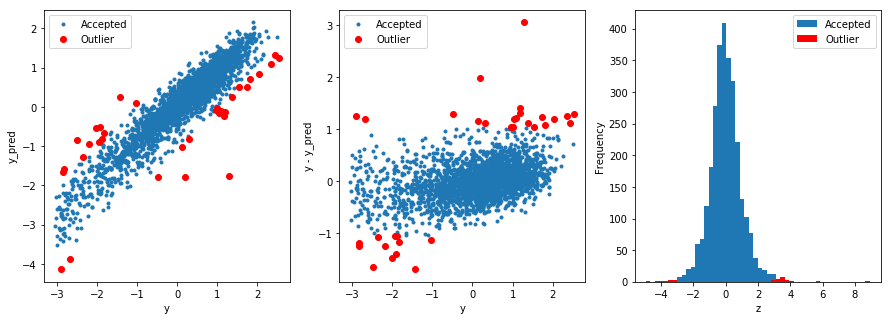

In [9]:
outliers = find_outliers(Ridge(), X, y)

X_outliers = X.loc[outliers]
y_outliers = y.loc[outliers]
X_t = X.drop(outliers)
y_t = y.drop(outliers)

In [ ]:
# hyperopt

In [12]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [13]:
NUM_EVALS = 1000
N_FOLDS = 5
XGB_MAX_LEAVES = 2**11
XGB_MAX_DEPTH = 25 
EVAL_METRIC_XGB_REG = 'rmse'

In [14]:
LGBM_MAX_LEAVES = 2**11
LGBM_MAX_DEPTH = 25
EVAL_METRIC_LGBM_REG = 'rmse'

In [15]:
def quick_hyperopt(data, labels, package='lgbm', num_evals=NUM_EVALS, diagnostic=False):
    
    #==========
    #LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth',
                         'num_leaves',
                          'max_bin',
                         'min_data_in_leaf',
                         'min_data_in_bin']
        
        def objective(space_params):
            
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            #extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            #for classification, set stratified=True and metrics=EVAL_METRIC_LGBM_CLASS
            cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=False,
                                early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
            
            best_loss = cv_results['rmse-mean'][-1] #'l2-mean' for rmse
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['auc-mean'][-1]
            #if necessary, replace 'auc-mean' with '[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        #integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['RMSE'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc'] #modify as required for other classification metrics
        objective_list_reg = ['huber',  'fair']
        objective_list_class = ['binary', 'cross_entropy']
        #for classification set objective_list = objective_list_class
        objective_list = objective_list_reg

        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        
        #optional: activate GPU for LightGBM
        #follow compilation steps here:
        #https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm/
        #then uncomment lines below:
        #space['device'] = 'gpu'
        #space['gpu_platform_id'] = 0,
        #space['gpu_device_id'] =  0

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
                
        #fmin() will return the index of values chosen from the lists/arrays in 'space'
        #to obtain actual values, index values are used to subset the original lists/arrays
        best['boosting'] = boosting_list[best['boosting']]['boosting']#nested dict, index twice
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #XGBoost
    #==========
    
    if package=='xgb':
        
        print('Running {} rounds of XGBoost parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth']
        
        def objective(space_params):
            
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract multiple nested tree_method conditional parameters
            #libera te tutemet ex inferis
            if space_params['tree_method']['tree_method'] == 'hist':
                max_bin = space_params['tree_method'].get('max_bin')
                space_params['max_bin'] = int(max_bin)
                if space_params['tree_method']['grow_policy']['grow_policy']['grow_policy'] == 'depthwise':
                    grow_policy = space_params['tree_method'].get('grow_policy').get('grow_policy').get('grow_policy')
                    space_params['grow_policy'] = grow_policy
                    space_params['tree_method'] = 'hist'
                else:
                    max_leaves = space_params['tree_method']['grow_policy']['grow_policy'].get('max_leaves')
                    space_params['grow_policy'] = 'lossguide'
                    space_params['max_leaves'] = int(max_leaves)
                    space_params['tree_method'] = 'hist'
            else:
                space_params['tree_method'] = space_params['tree_method'].get('tree_method')
                
            #for classification replace EVAL_METRIC_XGB_REG with EVAL_METRIC_XGB_CLASS
            cv_results = xgb.cv(space_params, train, nfold=N_FOLDS, metrics=[EVAL_METRIC_XGB_REG],
                             early_stopping_rounds=100, stratified=False, seed=42)
            
            best_loss = cv_results['test-rmse-mean'].iloc[-1] #or 'test-rmse-mean' if using RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['test-auc-mean'].iloc[-1]
            #if necessary, replace 'test-auc-mean' with 'test-[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = xgb.DMatrix(data, labels)
        
        #integer and string parameters, used with hp.choice()
        boosting_list = ['gbtree', 'gblinear'] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['rmse'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc']
        #modify as required for other classification metrics classification
        
        tree_method = [{'tree_method' : 'exact'},
               {'tree_method' : 'approx'},
               {'tree_method' : 'hist',
                'max_bin': hp.quniform('max_bin', 2**3, 2**7, 1),
                'grow_policy' : {'grow_policy': {'grow_policy':'depthwise'},
                                'grow_policy' : {'grow_policy':'lossguide',
                                                  'max_leaves': hp.quniform('max_leaves', 32, XGB_MAX_LEAVES, 1)}}}]
        
        #if using GPU, replace 'exact' with 'gpu_exact' and 'hist' with
        #'gpu_hist' in the nested dictionary above
        
        objective_list_reg = ['reg:linear']
        objective_list_class = ['reg:logistic', 'binary:logistic']
        #for classification change line below to 'objective_list = objective_list_class'
        objective_list = objective_list_reg
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'tree_method' : hp.choice('tree_method', tree_method),
                'max_depth': hp.quniform('max_depth', 2, XGB_MAX_DEPTH, 1),
                'reg_alpha' : hp.uniform('reg_alpha', 0, 5),
                'reg_lambda' : hp.uniform('reg_lambda', 0, 5),
                'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
                'gamma' : hp.uniform('gamma', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'eval_metric' : hp.choice('eval_metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01),
                'colsample_bynode' : hp.quniform('colsample_bynode', 0.1, 1, 0.01),
                'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),
                'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                'nthread' : 3
            }
        
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        best['tree_method'] = tree_method[best['tree_method']]['tree_method']
        best['boosting'] = boosting_list[best['boosting']]
        best['eval_metric'] = metric_list[best['eval_metric']]
        best['objective'] = objective_list[best['objective']]
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        if 'max_bin' in best:
            best['max_bin'] = int(best['max_bin'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)

In [22]:
lgb_params = quick_hyperopt(X_t, y_t, package='lgbm', num_evals=2000)

Running 2000 rounds of LightGBM parameter optimisation:
100%|███████| 2000/2000 [24:58<00:00,  1.12s/it, best loss: 0.3415612222402958]
{bagging_fraction: 0.56
boosting: goss
feature_fraction: 0.77
lambda_l1: 0.18350148706536196
lambda_l2: 3.260817180806637
learning_rate: 0.09847962888249102
max_bin: 125
max_depth: 17
metric: RMSE
min_data_in_bin: 93
min_data_in_leaf: 19
min_gain_to_split: 0.11
num_leaves: 1779
objective: huber
other_rate: 0.40918960559658013
top_rate: 0.2678133759359054}


In [24]:
lgb_params = {'bagging_fraction': 0.56,
            'boosting': 'goss',
            'feature_fraction': 0.77,
            'lambda_l1': 0.18350148706536196,
            'lambda_l2': 3.260817180806637,
            'learning_rate': 0.09847962888249102,
            'max_bin': 125,
            'max_depth': 17,
            'metric': 'RMSE',
            'min_data_in_bin': 93,
            'min_data_in_leaf': 19,
            'min_gain_to_split': 0.11,
            'num_leaves': 1779,
            'objective': 'huber',
            'other_rate': 0.40918960559658013,
            'top_rate': 0.2678133759359054}

In [25]:
MSE = 0
lgb_preds = np.zeros(len(test_data))
oof_lgb = np.zeros(len(X_t))
scores = []

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for fold, (train_idx, valid_idx) in enumerate(folds.split(y_t)):
#     print(train_idx)
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    model = lgb.LGBMRegressor(**lgb_params, n_estimators=20000, n_jobs=3)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=10000, early_stopping_rounds=1000)
    val_preds = model.predict(X_valid, num_iteration=model.best_iteration_)
    oof_lgb[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    lgb_preds += model.predict(test_data, num_iteration=model.best_iteration_) / n_fold
    scores.append(mean_squared_error(y_valid, val_preds))
    
print('CV score: {}, std: {}'.format(MSE, np.std(scores)))
# CV score: 0.11980723351606795, std: 0.012813405267478801

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[133]	training's rmse: 0.189415	valid_1's rmse: 0.343961
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[137]	training's rmse: 0.187377	valid_1's rmse: 0.37711
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[72]	training's rmse: 0.197902	valid_1's rmse: 0.333107
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[90]	training's rmse: 0.190865	valid_1's rmse: 0.315871
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[85]	training's rmse: 0.192759	valid_1's rmse: 0.359525
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[107]	training's rmse: 0.190331	valid_1's rmse: 0.324749
Training until validation scores don't improve for 1000 rounds.
Earl

In [16]:
xgb_params = quick_hyperopt(X_t, y_t, 'xgb', 3000, diagnostic=False)

Running 3000 rounds of XGBoost parameter optimisation:
100%|█████████████████| 3000/3000 [42:25<00:00,  1.01it/s, best loss: 0.401007]
{boosting: gbtree
colsample_bylevel: 0.29
colsample_bynode: 0.73
colsample_bytree: 0.97
eval_metric: rmse
gamma: 0.41332145844972545
learning_rate: 0.19964675210994973
max_depth: 8
min_child_weight: 3.3306534393618907
objective: reg:linear
reg_alpha: 0.3606307748824834
reg_lambda: 0.30545212622045936
subsample: 0.9500000000000001
tree_method: approx}


In [17]:
xgb_params = {'boosting': 'gbtree',
             'colsample_bylevel': 0.29,
             'colsample_bynode': 0.73,
             'colsample_bytree': 0.97,
             'eval_metric': 'rmse',
             'gamma': 0.41332145844972545,
             'learning_rate': 0.19964675210994973,
             'max_depth': 8,
             'min_child_weight': 3.3306534393618907,
             'objective': 'reg:linear',
             'reg_alpha': 0.3606307748824834,
             'reg_lambda': 0.30545212622045936,
             'subsample': 0.95,
             'tree_method': 'approx'}

{'boosting': 'gbtree',
 'colsample_bylevel': 0.29,
 'colsample_bynode': 0.73,
 'colsample_bytree': 0.97,
 'eval_metric': 'rmse',
 'gamma': 0.41332145844972545,
 'learning_rate': 0.19964675210994973,
 'max_depth': 8,
 'min_child_weight': 3.3306534393618907,
 'objective': 'reg:linear',
 'reg_alpha': 0.3606307748824834,
 'reg_lambda': 0.30545212622045936,
 'subsample': 0.9500000000000001,
 'tree_method': 'approx'}

In [19]:
MSE = 0
xgb_preds = np.zeros(len(test_data))
oof_xgb = np.zeros(len(X_t))
scores = []

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
#     print(train_idx)
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    model = xgb.XGBRegressor(**xgb_params, n_estimators=20000, early_stopping_rounds=1000, n_jobs=3)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=10000, early_stopping_rounds=1000)
    val_preds = model.predict(X_valid)
    oof_xgb[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    xgb_preds += model.predict(test_data) / n_fold
    scores.append(mean_squared_error(y_valid, val_preds))
    
print('CV score: {}, std: {}'.format(MSE, np.std(scores)))
# CV score: 0.1293704436757454, std: 0.010615129325500969

[0]	validation_0-rmse:0.861423	validation_1-rmse:0.858942
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
Stopping. Best iteration:
[328]	validation_0-rmse:0.164295	validation_1-rmse:0.361706

[0]	validation_0-rmse:0.856342	validation_1-rmse:0.899168
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
Stopping. Best iteration:
[92]	validation_0-rmse:0.168553	validation_1-rmse:0.37237

[0]	validation_0-rmse:0.861382	validation_1-rmse:0.866681
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
Stopping. Best iteration:
[1862]	validation_0-rmse:0.158074	validation_1-rmse:0.347528

[0]	validation_0-rmse:0.857882	validation_1-rmse:0.891747
Multiple eval metrics hav

In [27]:
def objective_rf(params):
    
    model = RandomForestRegressor(criterion='mse')
    scores = cross_val_score(model, X_t, y_t, cv=5, scoring='neg_mean_squared_error')
    MSE = -scores.mean()
    return {'loss': MSE, 'status': STATUS_OK}

space = {'n_estimators': hp.choice('n_estimators', range(20, 2000)),
         'max_depth': hp.choice('max_depth', range(3, 30)), 
         'min_samples_split': hp.choice('min_samples_split', range(2, 20)), 
         'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 20)),
         'max_features': hp.choice('max_features', range(3, 25)),
         'n_jobs': 3}

rf_params = fmin(fn=objective_rf,
                 space=space,
                 algo=tpe.suggest,
                 max_evals=2000)

100%|██████| 2000/2000 [53:25<00:00,  1.60s/it, best loss: 0.17184846715236426]


In [28]:
rf_params = {'max_depth': 8,
             'max_features': 15,
             'min_samples_leaf': 9,
             'min_samples_split': 5,
             'n_estimators': 1805}

{'max_depth': 8,
 'max_features': 15,
 'min_samples_leaf': 9,
 'min_samples_split': 5,
 'n_estimators': 1805}

In [29]:
MSE = 0
rf_preds = np.zeros(len(test_data))
oof_rf = np.zeros(len(X_t))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
#     print(train_idx)
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train, y_train)
    val_preds = rf.predict(X_valid)
    oof_rf[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    rf_preds += rf.predict(test_data) / n_fold
    
print('CV score: {}'.format(MSE))

CV score: 0.15141623109709965


In [24]:
oof_rf.shape

(2853,)

In [25]:
rf_preds.shape

(1925,)

In [30]:
def objective_kr(params):
    
    MSE = 0
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    for train_idx, valid_idx in folds.split(y_t):
    #     print(train_idx)
        X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
        y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
        model = KernelRidge(**params)
        model.fit(X_train, y_train)
        val_preds = model.predict(X_valid)
        MSE += mean_squared_error(y_valid, val_preds) / n_fold

    return {'loss': MSE, 'status': STATUS_OK}

space = {'alpha': hp.uniform('alpha', 0.01, 10),
         'kernel': hp.choice('kernel', ['linear', 'rbf', 'poly']),
         'gamma': hp.uniform('gamma', 0.01, 1),
         'degree': hp.choice('degree', range(1, 4)),
         'coef0': hp.uniform('coef0', 0, 10)}

kr_params = fmin(fn=objective_kr,
                 space=space,
                 algo=tpe.suggest,
                 max_evals=1000)

kr_params['kernel'] = ['linear', 'rbf', 'poly'][kr_params['kernel']]

100%|██████| 1000/1000 [24:10<00:00,  1.37s/it, best loss: 0.09280198215777763]


In [31]:
kr_params = {'alpha': 3.450600459134799,
             'coef0': 7.689915318550242,
             'degree': 1,
             'gamma': 0.02394333869271543,
             'kernel': 'poly'}

{'alpha': 3.450600459134799,
 'coef0': 7.689915318550242,
 'degree': 1,
 'gamma': 0.02394333869271543,
 'kernel': 'poly'}

In [32]:
MSE = 0
kr_preds = np.zeros(len(test_data))
oof_kr = np.zeros(len(X_t))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    kr = KernelRidge(**kr_params)
    kr.fit(X_train, y_train)
    val_preds = kr.predict(X_valid)
    oof_kr[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    kr_preds += kr.predict(test_data) / n_fold
    
print('CV score: {}'.format(MSE))

CV score: 0.10262846478585629


In [64]:
def objective_gbm(params):
    
    MSE = 0
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    
    model = GradientBoostingRegressor(**params, n_iter_no_change=200)
    scores = cross_val_score(model, X_t, y_t, cv=3, scoring='neg_mean_squared_error')
    MSE = -scores.mean()
    return {'loss': MSE, 'status': STATUS_OK}



space = {'loss': hp.choice('loss', ['ls', 'lad', 'huber', 'quantile']),
         'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
         'n_estimators': hp.choice('n_estimators', range(5000, 8000)),
         'max_depth': hp.choice('max_depth', range(3, 30)),
         'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 30)),
         'min_samples_split': hp.choice('min_samples_split', range(2, 300)),
         'max_features': hp.choice('max_features', range(1, 20)),
         'alpha': hp.uniform('alpha', 0, 1)}

gbm_params = fmin(fn=objective_gbm,
                  space=space,
                  algo=tpe.suggest,
                  max_evals=1000)

gbm_params['loss'] = ['ls', 'lad', 'huber', 'quantile'][gbm_params['loss']]

100%|███| 1000/1000 [16:49:43<00:00, 78.70s/it, best loss: 0.12577162101709474] 


In [65]:
gbm_params = {'alpha': 0.9360679087587133,
             'learning_rate': 0.005426460373788982,
             'loss': 'huber',
             'max_depth': 1,
             'max_features': 9,
             'min_samples_leaf': 14,
             'min_samples_split': 290,
             'n_estimators': 1727}

{'alpha': 0.9360679087587133,
 'learning_rate': 0.005426460373788982,
 'loss': 'huber',
 'max_depth': 1,
 'max_features': 9,
 'min_samples_leaf': 14,
 'min_samples_split': 290,
 'n_estimators': 1727}

In [67]:
MSE = 0
gbm_preds = np.zeros(len(test_data))
oof_gbm = np.zeros(len(X_t))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    gbm = GradientBoostingRegressor(**gbm_params)
    gbm.fit(X_train, y_train)
    val_preds = gbm.predict(X_valid)
    oof_gbm[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    gbm_preds += gbm.predict(test_data) / n_fold
    
print('CV score: {}'.format(MSE))

CV score: 0.18252688313861534


In [ ]:
def objective_svr(params):
    model = NuSVR(**params)
    scores = cross_val_score(model, X_t, y_t, cv=5, scoring='neg_mean_squared_error')
    MSE = -scores.mean()
    return {'loss': MSE, 'status': STATUS_OK}

space = {'C': hp.uniform('C', 0.1, 10.0),
         'nu': hp.uniform('nu', 0, 1.0),
         'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf']),
         'degree': hp.choice('degree', [1, 2, 3]),
         'gamma': hp.uniform('gamma', 0.01, 10),
         'coef0': hp.uniform('coef0', 0, 10)}

svr_params = fmin(fn=objective_svr,
                  space=space,
                  algo=tpe.suggest,
                  max_evals=1000)

  0%| | 1/1000 [01:03<17:38:55, 63.60s/it, best loss: 0.10785151866901369]

In [33]:
svr_params1 = {'gamma': 'scale', 'nu': 0.9, 'C': 10.0, 'tol': 0.01}

In [34]:
MSE = 0
svr_preds1 = np.zeros(len(test_data))
oof_svr1 = np.zeros(len(X_t))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    svr1 = NuSVR(**svr_params1)
    svr1.fit(X_train, y_train)
    val_preds = svr1.predict(X_valid)
    oof_svr1[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    svr_preds1 += svr1.predict(test_data) / n_fold
    
print('CV score: {}'.format(MSE))

CV score: 0.12962938077053374


In [35]:
svr_params2 = {'gamma': 'scale', 'nu': 0.7, 'C': 1.0, 'tol': 0.01}

In [36]:
MSE = 0
svr_preds2 = np.zeros(len(test_data))
oof_svr2 = np.zeros(len(X_t))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    svr2 = NuSVR(**svr_params2)
    svr2.fit(X_train, y_train)
    val_preds = svr2.predict(X_valid)
    oof_svr2[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    svr_preds2 += svr2.predict(test_data) / n_fold
    
print('CV score: {}'.format(MSE))

CV score: 0.11459351154088783


In [59]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=13, min_samples_split=23, min_samples_leaf=6),  
                        loss='square', learning_rate=1.0, n_estimators=700, random_state=1)

In [60]:
MSE = 0
ada_preds = np.zeros(len(test_data))
oof_ada = np.zeros(len(X_t))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    ada.fit(X_train, y_train)
    val_preds = ada.predict(X_valid)
    oof_ada[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    ada_preds += ada.predict(test_data) / n_fold
    
print('CV score: {}'.format(MSE))

CV score: 0.12489809336415758


In [61]:
stack_list = [oof_lgb, oof_xgb, oof_rf, oof_ada]
pred_list = [lgb_preds, xgb_preds, rf_preds, ada_preds]
columns = ['lgb', 'xgb', 'rf', 'ada']
train_stack = pd.DataFrame(np.vstack(stack_list).transpose(), columns=columns)
test_stack = pd.DataFrame(np.vstack(pred_list).transpose(), columns=columns)

In [62]:
train_stack

,lgb,xgb,rf,ada
0,0.133082,0.429748,-0.198855,0.150182
1,0.303197,0.232465,0.260532,0.298267
2,0.410074,0.181126,0.369354,0.515667
3,0.312226,0.403242,0.241236,0.357833
4,0.298027,0.179713,0.245468,0.262947
5,0.469155,0.465400,0.398665,0.355000
6,0.580365,0.520977,0.477321,0.429909
7,0.662979,0.595233,0.519993,0.546238
8,0.761885,0.740916,0.604001,0.657333
9,1.099321,1.031395,0.821436,1.017150


In [63]:
train_stack.corr()

,lgb,xgb,rf,ada
lgb,1.000000,0.982823,0.980628,0.986383
xgb,0.982823,1.000000,0.978226,0.984850
rf,0.980628,0.978226,1.000000,0.989553
ada,0.986383,0.984850,0.989553,1.000000


In [54]:
def objective_kr2(params):
    
    MSE = 0
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    for train_idx, valid_idx in folds.split(y_t):
    #     print(train_idx)
        X_train, X_valid = train_stack.iloc[train_idx], train_stack.iloc[valid_idx]
        y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
        model = KernelRidge(**params)
        model.fit(X_train, y_train)
        val_preds = model.predict(X_valid)
        MSE += mean_squared_error(y_valid, val_preds) / n_fold

    return {'loss': MSE, 'status': STATUS_OK}

space = {'alpha': hp.uniform('alpha', 0.01, 10),
         'kernel': hp.choice('kernel', ['linear']),
         'gamma': hp.uniform('gamma', 0.01, 1)}

kr_params2 = fmin(fn=objective_kr2,
                  space=space,
                  algo=tpe.suggest,
                  max_evals=1000)

100%|██████| 1000/1000 [20:00<00:00,  1.22s/it, best loss: 0.11692760031497108]


In [55]:
kr_params2 = {'alpha': 1.2377655531308462, 'gamma': 0.45466358839670284, 'kernel': 'linear'}

{'alpha': 1.2377655531308462, 'gamma': 0.45466358839670284, 'kernel': 'linear'}

In [56]:
MSE = 0
kr_preds2 = np.zeros(len(test_stack))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
    X_train, X_valid = train_stack.iloc[train_idx], train_stack.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    kr2 = KernelRidge(**kr_params2)
    kr2.fit(X_train, y_train)
    val_preds = kr2.predict(X_valid)
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    kr_preds2 += kr2.predict(test_stack) / n_fold
    
print('CV score: {}'.format(MSE))

CV score: 0.11677229353555461


In [57]:
kr_preds2

array([ 0.44636873,  0.11846287,  0.08916632, ..., -1.93910992,
       -1.96567283, -1.70841064])

In [58]:
pd.DataFrame(kr_preds2).to_csv('stack_lgb_xgb_rf.txt', index=False, header=False)

In [66]:
xgb_params2 = quick_hyperopt(train_stack, y_t, 'xgb', 3000, diagnostic=False)

In [46]:
MSE = 0
stack_preds = np.zeros(len(test_data))
feature_importance_stack = pd.DataFrame()

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for fold, (train_idx, valid_idx) in enumerate(folds.split(train_stack)):
    X_train, y_train = train_stack.iloc[train_idx], y_t.iloc[train_idx]
    X_valid, y_valid = train_stack.iloc[valid_idx], y_t.iloc[valid_idx]
    model = xgb.XGBRegressor(**xgb_params2, n_estimators=20000, n_jobs=3)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=10000, early_stopping_rounds=1000)
    val_pred = model.predict(X_valid)
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = train_stack.columns
    fold_importance['importance'] = model.feature_importances_
    fold_importance['fold'] = fold + 1
    MSE += mean_squared_error(y_valid, val_pred) / n_fold
    stack_preds += model.predict(test_stack) / n_fold
    feature_importance_stack = pd.concat([feature_importance_stack, fold_importance], axis=0)
    
print('CV score: {}'.format(MSE))

[0]	validation_0-rmse:0.845798	validation_1-rmse:0.858913
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
Stopping. Best iteration:
[101]	validation_0-rmse:0.246986	validation_1-rmse:0.303039

[0]	validation_0-rmse:0.844233	validation_1-rmse:0.871277
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
Stopping. Best iteration:
[23]	validation_0-rmse:0.254226	validation_1-rmse:0.294708

[0]	validation_0-rmse:0.847506	validation_1-rmse:0.838659
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
Stopping. Best iteration:
[18]	validation_0-rmse:0.259822	validation_1-rmse:0.271632

[0]	validation_0-rmse:0.843249	validation_1-rmse:0.871691
Multiple eval metrics have

In [47]:
pd.DataFrame(stack_preds).to_csv('stack_lgb_xgb_rf_kr_gbm_svr12.txt', index=False, header=False)

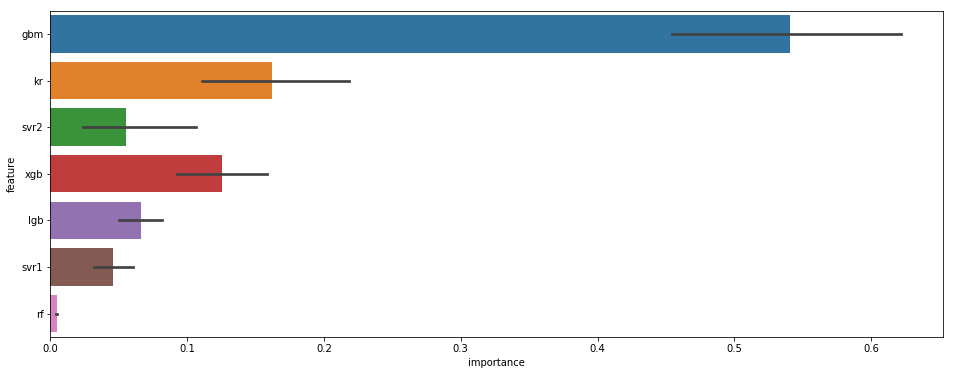

In [65]:
fig = plt.figure(figsize=(16, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_stack.sort_values(by='importance', ascending=False))
plt.show()

In [35]:
lgb_params2 = quick_hyperopt(train_stack, y_t, package='lgbm', num_evals=3000, diagnostic=False)

Running 3000 rounds of LightGBM parameter optimisation:
100%|█| 3000/3000 [31:12<00:00,  1.02s/it, best loss: 0.3150225250720053] 
{bagging_fraction: 0.58
boosting: gbdt
feature_fraction: 0.59
lambda_l1: 0.0027492236181156596
lambda_l2: 0.09922282062823436
learning_rate: 0.10149545781981265
max_bin: 247
max_depth: 18
metric: RMSE
min_data_in_bin: 20
min_data_in_leaf: 6
min_gain_to_split: 0.1
num_leaves: 73
objective: huber
subsample: 0.6968388320474507}


In [36]:
lgb_params2

{'bagging_fraction': 0.58,
 'boosting': 'gbdt',
 'feature_fraction': 0.59,
 'lambda_l1': 0.0027492236181156596,
 'lambda_l2': 0.09922282062823436,
 'learning_rate': 0.10149545781981265,
 'max_bin': 247,
 'max_depth': 18,
 'metric': 'RMSE',
 'min_data_in_bin': 20,
 'min_data_in_leaf': 6,
 'min_gain_to_split': 0.1,
 'num_leaves': 73,
 'objective': 'huber',
 'subsample': 0.6968388320474507}

In [38]:
MSE = 0
stack_preds = np.zeros(len(test_data))
feature_importance_stack = pd.DataFrame()

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for fold, (train_idx, valid_idx) in enumerate(folds.split(train_stack)):
    X_train, y_train = train_stack.iloc[train_idx], y_t.iloc[train_idx]
    X_valid, y_valid = train_stack.iloc[valid_idx], y_t.iloc[valid_idx]
    model = lgb.LGBMRegressor(**lgb_params2, n_estimators=20000, n_jobs=3)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=10000, early_stopping_rounds=1000)
    val_pred = model.predict(X_valid)
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = train_stack.columns
    fold_importance['importance'] = model.feature_importances_
    fold_importance['fold'] = fold + 1
    MSE += mean_squared_error(y_valid, val_pred) / n_fold
    stack_preds += model.predict(test_stack) / n_fold
    feature_importance_stack = pd.concat([feature_importance_stack, fold_importance], axis=0)
    
print('CV score: {}'.format(MSE))

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[44]	training's rmse: 0.221508	valid_1's rmse: 0.310171
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[57]	training's rmse: 0.2204	valid_1's rmse: 0.296692
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[54]	training's rmse: 0.222242	valid_1's rmse: 0.272112
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[56]	training's rmse: 0.220091	valid_1's rmse: 0.287977
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[48]	training's rmse: 0.221886	valid_1's rmse: 0.282137
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[55]	training's rmse: 0.221928	valid_1's rmse: 0.29412
Training until validation scores don't improve for 1000 rounds.
Early sto

In [39]:
pd.DataFrame(stack_preds).to_csv('stack_lgb_xgb_rf_kr_gbm_svr12_2.txt', index=False, header=False)